In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')



In [27]:
train_df

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.8200,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.1700,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.7400,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.3900,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.4300,2004,200801,21~31,3,120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,1234823,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,59.8245,2012,201711,11~20,3,22000
1216549,1234824,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,7,30750
1216550,1234825,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,9,29500
1216551,1234826,9586,부산광역시,정관읍 용수리,1364,정관신도시롯데캐슬,정관읍 용수리 1364 정관신도시롯데캐슬,101.7400,2008,201711,21~30,7,26700


In [28]:
train_df.iloc[:,[3,5]]

,dong,apt
0,신교동,신현(101동)
1,필운동,사직파크맨션
2,필운동,두레엘리시안
3,내수동,파크팰리스
4,내수동,킹스매너
...,...,...
1216548,정관읍 용수리,정관 동일스위트1차
1216549,정관읍 용수리,정관 동일스위트1차
1216550,정관읍 용수리,정관 동일스위트1차
1216551,정관읍 용수리,정관신도시롯데캐슬


In [29]:
# exclusive_use_area: 전용면적(한 세대만 독점적으로 사용하는 공간)

# transaction_real_price: 실거래가(단위:만원, 타겟 값, train만 존재)

# transaction_year_month: 거래년월

# transaction_date: 거래일

# floor: 층


In [30]:
train_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [31]:
train_df.loc[train_df['transaction_real_price'],].max()
train_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [32]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [33]:
train_df.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500


In [34]:
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train_df))):
   train_df.at[i, 'apt'] = re.sub(regex, '', train_df.at[i, 'apt'])
for i in tqdm(range(len(test_df))):
   test_df.at[i, 'apt'] = re.sub(regex, '', test_df.at[i, 'apt']) 



100%|██████████| 5463/5463 [00:00<00:00, 65908.30it/s]


In [35]:
train_df['apt'].value_counts()[:20]

현대        17716
한신        10135
삼성         6771
대우         6390
신동아        6386
두산         5801
우성         5781
주공2        5669
삼성래미안      5483
벽산         4651
대림         4582
동원로얄듀크     4430
경남         4030
삼환         3896
극동         3771
삼익         3583
롯데캐슬       3570
쌍용         3409
코오롱        3320
한양         3231
Name: apt, dtype: int64

In [36]:
# 같은 아파트 이름을 갖는 수를 저장하는 apt_counts 열 생성

train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()

train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x',axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test_df['apt_counts'] = 0
test_df.groupby('apt')['apt_counts'].count()
test_df = pd.merge(test_df, test_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500,13


In [37]:
train_df['top10'] = 0
test_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
# top 10 시공사면 1, 아니면 0 
# enumerate : 반복문 사용 시 몇 번째 반복문인지 확인이 필요할 수 있습니다. 이때 사용합니다.
# 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환합니다.
# str.contains : 문자열 검
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand),'top10'] = 1
    test_df.loc[train_df['apt'].str.contains(brand),'top10'] = 1

In [38]:
# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']

# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train_df['transformed'] = False
test_df['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    test_df.loc[test_df['apt'].str.contains(a), 'apt'] = a
    train_df.loc[train_df['apt'].str.contains(a), 'transformed'] = True
    test_df.loc[test_df['apt'].str.contains(a), 'transformed'] = True

100%|██████████| 35/35 [00:48<00:00,  1.39s/it]


In [39]:
# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    train_df.loc[~train_df['transformed'], 'apt'] = 'others'
    test_df.loc[~test_df['transformed'] , 'apt'] = 'others'

100%|██████████| 25/25 [00:00<00:00, 25.93it/s]


In [40]:
train_df['apt'].value_counts()


others          653503
현대               81824
주공               65937
래미안              32743
한신               27481
벽산               26968
우성               24524
롯데캐슬             24053
삼성               20067
sk|SK|에스케이       19709
두산               19501
삼익               18708
푸르지오             18416
쌍용               18256
대림               18194
대우               17786
이편한|e편한|e-편한     14337
신동아              14049
힐스테이트            11985
자이               11719
엘지               10938
경남               10875
코오롱               8602
아이파크              7989
성원                7601
더샵                6977
삼환                6073
동원로얄듀크            6070
파크리오              3094
잠실                2606
동성                2228
데시앙               2222
양지                1033
그레이스               393
동궁리치웰               92
Name: apt, dtype: int64

In [41]:
# 아파트별 가격의 평균 내림차순 정렬
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])


for i,a in enumerate(list(apt_price.index)):
    train_df.loc[train_df['apt']==a,'apt'] = i
    test_df.loc[train_df['apt']==a,'apt'] = i
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)




변환전
 apt
잠실      91273.525326
파크리오    88739.646736
자이      79838.112467
래미안     64184.531289
아이파크    63115.982726
Name: transaction_real_price, dtype: float64


In [42]:
# 주소의 동 
# 같은 이름을 가진 동 확인
# set로 서울과 부산 동의 중복제거 후 & and 연산자 사용하여 같은 부분 출력
seoul_set = set(train_df.loc[train_df['city']=='서울특별시','dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시','dong'])
same_dong = seoul_set & busan_set
print(same_dong)

seoul_set = set(test_df.loc[test_df['city']=='서울특별시', 'dong'])
busan_set = set(test_df.loc[test_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

{'사직동', '중동', '송정동', '부암동'}
{'사직동', '중동', '송정동', '부암동'}


In [43]:
for d in same_dong:
    train_df.loc[(train_df['city']=='서울특별시') & (train_df['dong']==d), 'dong'] = '서울' + d
    train_df.loc[(train_df['city']=='부산광역시') & (train_df['dong']==d), 'dong'] = '부산' + d
    test_df.loc[(test_df['city']=='서울특별시') & (test_df['dong']==d), 'dong'] = '서울' + d
    test_df.loc[(test_df['city']=='부산광역시') & (test_df['dong']==d), 'dong'] = '부산' + d
    

seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)  

set()


In [44]:
train_df.loc[train_df['dong'].str.contains('장충동')].groupby('dong')['transaction_real_price'].mean()

train_df

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,신교동,6-13,23,신교동 6-13 신현(101동),84.8200,2002,200801,21~31,2,37500,13,0,False
1,1,5399,서울특별시,필운동,142,23,필운동 142 사직파크맨션,99.1700,1973,200801,1~10,6,20000,1,0,False
2,2,3578,서울특별시,필운동,174-1,23,필운동 174-1 두레엘리시안,84.7400,2007,200801,1~10,6,38500,13,0,False
3,3,10957,서울특별시,내수동,95,23,내수동 95 파크팰리스,146.3900,2003,200801,11~20,15,118000,55,0,False
4,4,10639,서울특별시,내수동,110-15,23,내수동 110-15 킹스매너,194.4300,2004,200801,21~31,3,120000,15,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,1234823,9578,부산광역시,정관읍 용수리,1387,23,정관읍 용수리 1387 정관 동일스위트1차,59.8245,2012,201711,11~20,3,22000,837,0,False
1216549,1234824,9578,부산광역시,정관읍 용수리,1387,23,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,7,30750,837,0,False
1216550,1234825,9578,부산광역시,정관읍 용수리,1387,23,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,9,29500,837,0,False
1216551,1234826,9586,부산광역시,정관읍 용수리,1364,10,정관읍 용수리 1364 정관신도시롯데캐슬,101.7400,2008,201711,21~30,7,26700,1020,1,True


In [45]:
dong_price = train_df.groupby('dong')['transaction_real_price'].mean().sort_values(ascending=False)
dong_price

dong
장충동1가      269888.888889
압구정동       164534.722914
청암동        161403.700000
용산동5가      153497.331633
회현동2가      139906.140351
               ...      
중앙동4가        6312.500000
봉래동5가        5732.546012
신창동2가        5531.250000
장안읍 명례리      5508.333333
신선동3가        5500.000000
Name: transaction_real_price, Length: 477, dtype: float64

In [46]:
for i,d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    train_df.loc[train_df['dong'] == d,'dong'] = i
    test_df.loc[test_df['dong'] == d, 'dong'] = i

100%|██████████| 477/477 [00:50<00:00,  9.43it/s]


In [47]:
train_df['floor'] = train_df['floor'].map(lambda x:x+4)
test_df['floor'] = test_df['floor'].map(lambda x:x+1)

<Figure size 640x480 with 0 Axes>

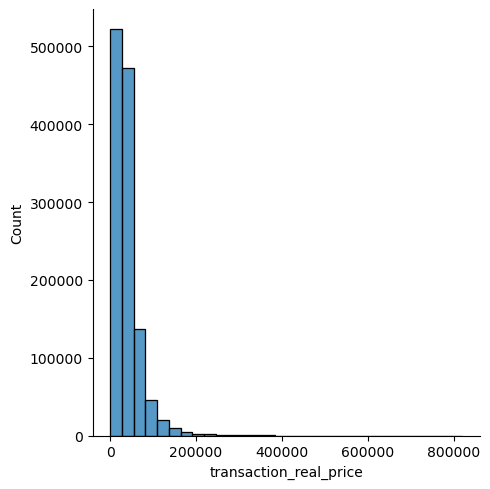

In [48]:
# 타겟데이터 price
plt.figure()
sns.displot(train_df['transaction_real_price'],bins=30)
plt.show()

In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  bool   
 3   dong                    1216553 non-null  int64  
 4   jibun                   1216553 non-null  object 
 5   apt                     1216553 non-null  int64  
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
 13  apt_counts              1216553 non-null  int64  
 14  to

In [65]:
train = train_df.iloc[:,[1,2,4,5,8,11,12,13,14]]
train_df.str.constrain("부산광역시")

,apartment_id,city,jibun,apt,year_of_completion,floor,transaction_real_price,apt_counts,top10
0,7622,False,6-13,23,2002,6,37500,13,0
1,5399,False,142,23,1973,10,20000,1,0
2,3578,False,174-1,23,2007,10,38500,13,0
3,10957,False,95,23,2003,19,118000,55,0
4,10639,False,110-15,23,2004,7,120000,15,0
...,...,...,...,...,...,...,...,...,...
1216548,9578,False,1387,23,2012,7,22000,837,0
1216549,9578,False,1387,23,2012,11,30750,837,0
1216550,9578,False,1387,23,2012,13,29500,837,0
1216551,9586,False,1364,10,2008,11,26700,1020,1


In [67]:
test_Df.info()

NameError: name 'test_Df' is not defined